# ACP-MHCNN paper implementation 
## They have given .noy files which are blosum26 representation of peptitdes

In [1]:
try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print('We\'re using TF-{}.'.format(tf.__version__))

2023-06-02 02:37:13.839412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 02:37:14.897885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We're using TF-2.12.0.


In [2]:
#Let's load the data from the clonned repo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical as labelEncoding  #for label encoding
#Binary profile Features
T = 20 # terminus_length

X1train = np.load('bpf-500.npy')
X2train = np.load('bits-500.npy')
X3train = np.load('blosum-500.npy')

X1train = X1train[:,0:T,:]
X2train = X2train[:,0:T,:]
X3train = X3train[:,0:T,:]

print(X1train.shape)
print(X2train.shape)
print(X3train.shape)


print('### --- --- --- --- --- ###')


X1test = np.load('bpf-164.npy')
X2test = np.load('bits-164.npy')
X3test = np.load('blosum-164.npy')

X1test = X1test[:,0:T,:]
X2test = X2test[:,0:T,:]
X3test = X3test[:,0:T,:]

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

print('### --- --- --- --- --- ###')

# ACP {500, 164}
Ytrain  = [0 for _ in range(250)]
Ytrain += [1 for _ in range(250)]
Ytrain  = np.array(Ytrain)

Ytest  = [0 for _ in range(82)]
Ytest += [1 for _ in range(82)]

Ytrain = labelEncoding(Ytrain, dtype=int)
Ytest  = labelEncoding(Ytest, dtype=int)

(500, 20, 20)
(500, 20, 31)
(500, 20, 20)
### --- --- --- --- --- ###
(164, 20, 20)
(164, 20, 31)
(164, 20, 20)
### --- --- --- --- --- ###


In [3]:
def globalFeatureConcat(X1, X2, X3):
    V = []
    for x1,x2,x3 in zip(X1, X2, X3):
        v = np.concatenate((x1, x2, x3), axis=1)
        V.append(v)
    #end-for
    return np.array(V)

Xtrain = globalFeatureConcat(X1train, X2train, X3train)
Xtest  = globalFeatureConcat(X1test,  X2test,  X3test)

In [6]:
Y  = [1 for _ in range(129)]
Y += [0 for _ in range(111)]
Y = labelEncoding(Y, dtype=int)


In [16]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)

#end-import

We're using TF-2.12.0.


In [4]:

def Network():
    ### Head-1:
    input1 = Input(shape=Xtrain[0].shape)

    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.50)(x)

    head1 = Flatten()(x)


    output = Dense(units=16, activation='relu',)(head1)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.60)(output)
    
    output = Dense(units=8, activation='relu',)(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.50)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1], outputs=[output])

2023-06-02 02:37:20.011363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 02:37:20.048575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-02 02:37:20.048798: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 71)]          0         
                                                                 
 conv1d (Conv1D)             (None, 20, 16)            3424      
                                                                 
 batch_normalization (BatchN  (None, 20, 16)           64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 8)             392       
                                                                 
 batch_normalization_1 (Batc  (None, 20, 8)            32        
 hNormalization)                                             

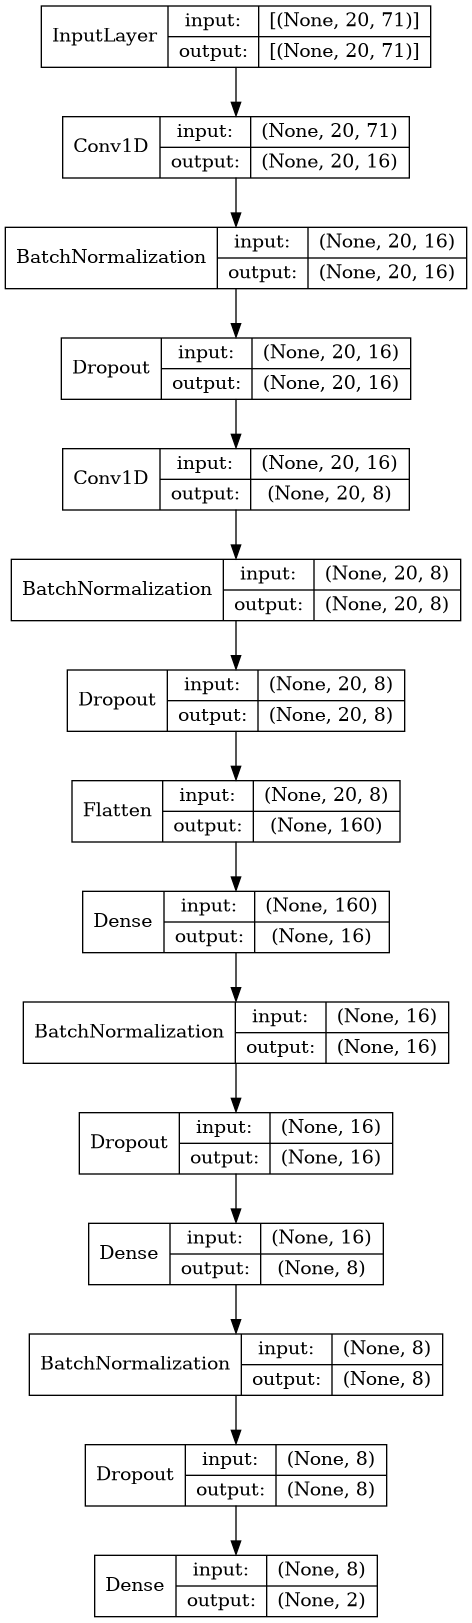

In [5]:
model = Network()
model.summary()
plot_model(model, to_file='model-single-Head-500-164.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [ ]:
setEpochNumber     = 10       ### 2,500 performed well!
setBatchSizeNumber = 16


model = Network()
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Run Model:
results = model.fit(x=Xtrain,
                    y=Ytrain,
                    validation_data=(Xtest, Ytest),
                    batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                    verbose=1,
                    callbacks=[])
    
# Evaluate the Model:
accuracy = model.evaluate(x=Xtest, y=Ytest)


Epoch 1/600
63/63 [==============================] - 4s 14ms/step - loss: 1.6297 - accuracy: 0.4600 - val_loss: 1.1580 - val_accuracy: 0.5549
Epoch 2/600
63/63 [==============================] - 1s 9ms/step - loss: 1.3518 - accuracy: 0.5260 - val_loss: 1.0329 - val_accuracy: 0.6037
Epoch 3/600
63/63 [==============================] - 1s 9ms/step - loss: 1.1103 - accuracy: 0.5360 - val_loss: 1.0121 - val_accuracy: 0.5610
Epoch 4/600
63/63 [==============================] - 1s 8ms/step - loss: 1.0393 - accuracy: 0.5100 - val_loss: 0.9889 - val_accuracy: 0.5183
Epoch 5/600
63/63 [==============================] - 0s 7ms/step - loss: 0.9957 - accuracy: 0.5180 - val_loss: 0.9591 - val_accuracy: 0.5244
Epoch 6/600
63/63 [==============================] - 0s 7ms/step - loss: 0.9557 - accuracy: 0.4960 - val_loss: 0.9309 - val_accuracy: 0.5366
Epoch 7/600
63/63 [==============================] - 1s 10ms/step - loss: 0.9270 - accuracy: 0.5160 - val_loss: 0.9083 - val_accuracy: 0.5061
Epoch 8/600

/tmp/ipykernel_108848/1632273058.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  TPR.append(interp(meanFPR, fpr, tpr))


63/63 [==============================] - 3s 9ms/step - loss: 1.6978 - accuracy: 0.4620 - val_loss: 1.1055 - val_accuracy: 0.4634
Epoch 2/600
63/63 [==============================] - 0s 6ms/step - loss: 1.2659 - accuracy: 0.5360 - val_loss: 1.0881 - val_accuracy: 0.4451
Epoch 3/600
63/63 [==============================] - 0s 7ms/step - loss: 1.1646 - accuracy: 0.4780 - val_loss: 1.0418 - val_accuracy: 0.4634
Epoch 4/600
63/63 [==============================] - 0s 6ms/step - loss: 1.0610 - accuracy: 0.4940 - val_loss: 1.0114 - val_accuracy: 0.4451
Epoch 5/600
63/63 [==============================] - 0s 6ms/step - loss: 1.0063 - accuracy: 0.5080 - val_loss: 0.9813 - val_accuracy: 0.5000
Epoch 6/600
63/63 [==============================] - 0s 7ms/step - loss: 0.9746 - accuracy: 0.5000 - val_loss: 0.9565 - val_accuracy: 0.4695
Epoch 7/600
63/63 [==============================] - 0s 6ms/step - loss: 0.9427 - accuracy: 0.5420 - val_loss: 0.9308 - val_accuracy: 0.5061
Epoch 8/600
63/63 [======

/tmp/ipykernel_108848/1632273058.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  TPR.append(interp(meanFPR, fpr, tpr))


Epoch 1/600
63/63 [==============================] - 5s 12ms/step - loss: 1.3612 - accuracy: 0.5020 - val_loss: 1.0713 - val_accuracy: 0.4634
Epoch 2/600
63/63 [==============================] - 1s 8ms/step - loss: 1.1170 - accuracy: 0.5100 - val_loss: 1.0146 - val_accuracy: 0.5061
Epoch 3/600
63/63 [==============================] - 1s 9ms/step - loss: 1.0130 - accuracy: 0.5460 - val_loss: 0.9709 - val_accuracy: 0.5610
Epoch 4/600
63/63 [==============================] - 1s 8ms/step - loss: 0.9603 - accuracy: 0.5460 - val_loss: 0.9338 - val_accuracy: 0.5915
Epoch 5/600
63/63 [==============================] - 1s 9ms/step - loss: 0.9329 - accuracy: 0.5040 - val_loss: 0.9010 - val_accuracy: 0.5305
Epoch 6/600
63/63 [==============================] - 1s 10ms/step - loss: 0.8943 - accuracy: 0.5320 - val_loss: 0.8708 - val_accuracy: 0.5244
Epoch 7/600
63/63 [==============================] - 1s 10ms/step - loss: 0.8720 - accuracy: 0.4840 - val_loss: 0.8475 - val_accuracy: 0.6037
Epoch 8/60

/tmp/ipykernel_108848/1632273058.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  TPR.append(interp(meanFPR, fpr, tpr))


Epoch 1/600
63/63 [==============================] - 6s 17ms/step - loss: 1.3894 - accuracy: 0.4860 - val_loss: 1.0743 - val_accuracy: 0.5183
Epoch 2/600
63/63 [==============================] - 1s 11ms/step - loss: 1.1204 - accuracy: 0.5260 - val_loss: 1.0383 - val_accuracy: 0.4939
Epoch 3/600
63/63 [==============================] - 1s 10ms/step - loss: 1.0437 - accuracy: 0.5320 - val_loss: 0.9866 - val_accuracy: 0.5000
Epoch 4/600
63/63 [==============================] - 1s 9ms/step - loss: 0.9773 - accuracy: 0.5100 - val_loss: 0.9440 - val_accuracy: 0.5122
Epoch 5/600
63/63 [==============================] - 1s 13ms/step - loss: 0.9384 - accuracy: 0.5080 - val_loss: 0.9065 - val_accuracy: 0.5366
Epoch 6/600
63/63 [==============================] - 1s 11ms/step - loss: 0.9051 - accuracy: 0.4560 - val_loss: 0.8779 - val_accuracy: 0.5305
Epoch 7/600
63/63 [==============================] - 1s 11ms/step - loss: 0.8671 - accuracy: 0.5100 - val_loss: 0.8504 - val_accuracy: 0.5122
Epoch 8

/tmp/ipykernel_108848/1632273058.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  TPR.append(interp(meanFPR, fpr, tpr))


63/63 [==============================] - 4s 9ms/step - loss: 1.3772 - accuracy: 0.4940 - val_loss: 1.0311 - val_accuracy: 0.5549
Epoch 2/600
63/63 [==============================] - 0s 7ms/step - loss: 1.1151 - accuracy: 0.4880 - val_loss: 1.0051 - val_accuracy: 0.5061
Epoch 3/600
63/63 [==============================] - 0s 7ms/step - loss: 1.0108 - accuracy: 0.5320 - val_loss: 0.9680 - val_accuracy: 0.5244
Epoch 4/600
63/63 [==============================] - 0s 7ms/step - loss: 0.9709 - accuracy: 0.5100 - val_loss: 0.9378 - val_accuracy: 0.4939
Epoch 5/600
63/63 [==============================] - 0s 6ms/step - loss: 0.9215 - accuracy: 0.5240 - val_loss: 0.9037 - val_accuracy: 0.4817
Epoch 6/600
63/63 [==============================] - 0s 7ms/step - loss: 0.8976 - accuracy: 0.5040 - val_loss: 0.8752 - val_accuracy: 0.5122
Epoch 7/600
63/63 [==============================] - 0s 7ms/step - loss: 0.8634 - accuracy: 0.5420 - val_loss: 0.8506 - val_accuracy: 0.5183
Epoch 8/600
63/63 [======

/tmp/ipykernel_108848/1632273058.py:66: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  TPR.append(interp(meanFPR, fpr, tpr))


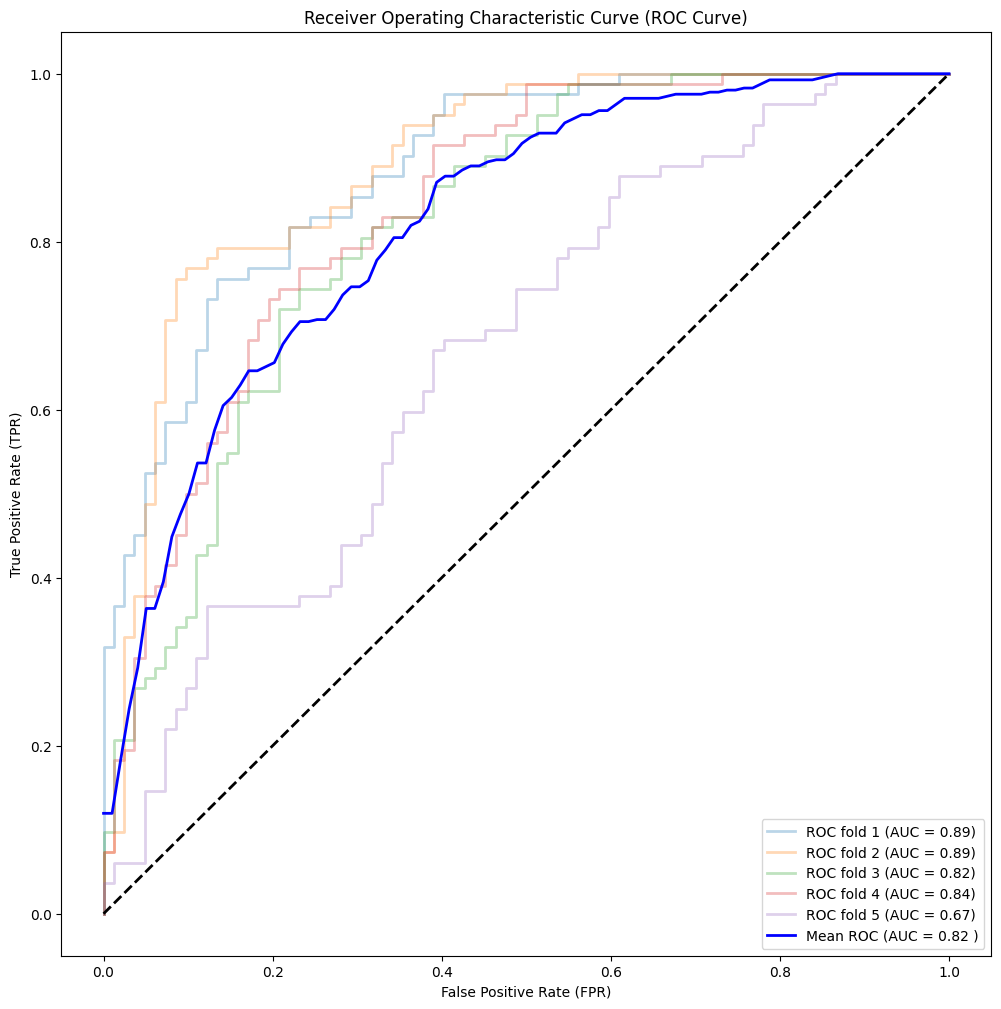

Accuracy [Each Fold]: [0.7987805008888245, 0.7743902206420898, 0.7317073345184326, 0.7621951103210449, 0.542682945728302]
Accuracy: 0.72
Sensitivity: 0.6976
Specificity: 0.7463
MCC: 0.4655
Precision: 0.7331
Accuracy [Each Fold]: [0.7987805008888245, 0.7743902206420898, 0.7317073345184326, 0.7621951103210449, 0.542682945728302]
Accuracy: 0.72


In [18]:
def rocPlot(TPR, meanFPR):
    plt.plot([0,1], [0,1],linestyle = '--',lw = 2,color = 'black')
    meanTPR = np.mean(TPR, axis=0)
    meanAUC = auc(meanFPR, meanTPR)
    plt.plot(meanFPR, meanTPR, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (meanAUC),lw=2, alpha=1)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
    plt.legend(loc="lower right")
    plt.savefig('ROC-240.png')
    plt.show()
#end-def


setEpochNumber     = 600     # Performed-welled in epoch 600.
setBatchSizeNumber = 8
cv = KFold(n_splits=5, shuffle=True, random_state=101)
Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# ROC Curve:
fig1 = plt.figure(figsize=[12,12])

TPR = []
meanFPR = np.linspace(0, 1, 100)

i = 1
for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=Xtrain,
                        y=Ytrain,
                        validation_data=(Xtest, Ytest),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                        verbose=1,
                        callbacks=[])
    accuracy = model.evaluate(x=Xtest, y=Ytest)
    Accuracy.append(accuracy[1])

    # Performance Metices:
    Yactual = Ytest.argmax(axis=1)
    Yp = model.predict(Xtest)
    v = Yp
    Yp = Yp.argmax(axis=1)
    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(Yactual, v[:,1])
    TPR.append(interp(meanFPR, fpr, tpr))
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, rocauc))
    i= i+1
    
    # # Performance Plot
    # print('#################################################')
    # print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    # lossPlot(results)
    # accuracyPlot(results)
    # print('#################################################')

    
#end-for

rocPlot(TPR, meanFPR)

print('Accuracy [Each Fold]: {}'.format(Accuracy))
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))
#end-for

print('Accuracy [Each Fold]: {}'.format(Accuracy))
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))